# Transfer Learning Network
**Name Student:**Ido Zemel<br></br>

### Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive_dir = '/mntDrive'
drive.mount(drive_dir)

#Project dir inside the drive
main_drive_dir = drive_dir + '/MyDrive/DeepLearning/adv_end'

#Dataset dir
data_dir = main_drive_dir + '/Kaggle/data_new'

#Train & test dir
train_dir = data_dir + '/train_new'
test_dir = data_dir + '/test_new'


Mounted at /mntDrive


### Data Preprocessing

Our data preprocessing we commited on our CNN notebook.
we have devided the data from over 10k pictures of 120breeds of dogs, into 6k pictures of 120breeds of dogs.
Our data is made of 40 images for each breed(4800) for training and 10 images for each breed(1200) for test.

our data preprocessing can be seen here : https://drive.google.com/file/d/11OTLkUtZwSyLODNkFQYLXH-dzYKlzSsh/view?usp=sharing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get random image path and class
def get_random_image():
  random_class_index = np.random.randint(1,120)
  random_image_index = np.random.randint(1, 40)

  random_class_name = os.listdir(train_dir)[random_class_index]
  random_image_name = os.listdir(train_dir + '/' + random_class_name)[random_image_index]

  image_path = train_dir + '/' + random_class_name + '/' + random_image_name
  return (image_path,random_class_name)

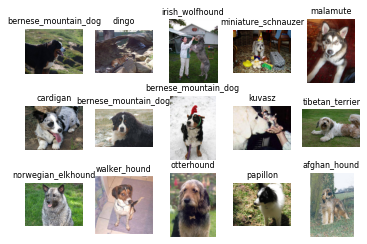

In [ ]:
from PIL import Image

# Setting the no of rows and columns
num_row, num_col = 3, 5

# Display images
for i in range(num_row * num_col):
    img_path, img_class = get_random_image()
    sp = plt.subplot(num_row, num_col, i+1)
    # turn off axis
    sp.axis('Off')
    # read image as an array
    img = mpimg.imread(img_path)
    # setting title of plot as the filename
    sp.set_title(img_class, fontsize=8)
    # display image
    plt.imshow(img, cmap='gray')
    
# display the plot
plt.show()

Before we start training our model, we would like to save each model for using it afterwards. </br>
For that we will create a new folder for models.

In [ ]:
model_dir = main_drive_dir + "/models"
os.mkdir(model_dir)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense,Flatten,Activation,Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.applications.xception import preprocess_input

First of all we need to set up our data before starting.

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   brightness_range=[0.5,1.4],
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_dataset = train_datagen.flow_from_directory(batch_size=32,
                                                 directory='/mntDrive/MyDrive/DeepLearning/adv_end/Kaggle/data_new/train_new',
                                                 shuffle=True,
                                                 target_size=(299, 299), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = train_datagen.flow_from_directory(batch_size=32,
                                                 directory='/mntDrive/MyDrive/DeepLearning/adv_end/Kaggle/data_new/train_new',
                                                 shuffle=True,
                                                 target_size=(299, 299), 
                                                 subset="validation",
                                                 class_mode='categorical')

test_dataset = test_datagen.flow_from_directory(batch_size=32,
                                                 directory='/mntDrive/MyDrive/DeepLearning/adv_end/Kaggle/data_new/test_new',
                                                 shuffle=True,
                                                 target_size=(299, 299), 
                                                 class_mode='categorical')


Found 3840 images belonging to 120 classes.
Found 960 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


In [ ]:
#Our image size input is 299,299,3
input_size = 299
input = Input((input_size,input_size,3))
#The maximum epochs we will run
EPOCH = 60

# Experiment number 1 (The Chosen architecture): InceptionResNetV2

In [ ]:
#Our first model import
from tensorflow.keras.applications import InceptionResNetV2

## Loading&Building NN

 Loading the Base Model </br>
We will be using only the basic models, with changes made only to the final layer. This is because this is just for classification problem with 120 classes while these models are built to handle up to 1000 classes.

In [ ]:
model = InceptionResNetV2(input_tensor=input,
                          include_top=False,
                          weights="imagenet")

Compile and Fit </br>
We will then build the last fully-connected layer.

In [ ]:
#Make every layer untrainable.
model.trainable = False
# add new classifier layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(120, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

## Training NN

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = [
      EarlyStopping(
          monitor='val_accuracy',
          mode='max', patience=5,
          restore_best_weights=True),
      ModelCheckpoint(model_dir + '/InceptionResNetV2.h5',
                      verbose=1,
                      monitor='val_accuracy',
                      save_best_only=True), 
]

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
InceptionResNetV2_history = model.fit(x = train_dataset, validation_data = validation_dataset, epochs = EPOCH, callbacks=[es])

Epoch 1/60
120/120 [==============================] - ETA: 0s - loss: 2.2017 - accuracy: 0.5529
Epoch 1: val_accuracy improved from -inf to 0.76979, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionResNetV2.h5
120/120 [==============================] - 193s 2s/step - loss: 2.2017 - accuracy: 0.5529 - val_loss: 0.9325 - val_accuracy: 0.7698
Epoch 2/60
120/120 [==============================] - ETA: 0s - loss: 0.9419 - accuracy: 0.7576
Epoch 2: val_accuracy improved from 0.76979 to 0.77083, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionResNetV2.h5
120/120 [==============================] - 179s 1s/step - loss: 0.9419 - accuracy: 0.7576 - val_loss: 0.8335 - val_accuracy: 0.7708
Epoch 3/60
120/120 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.7792
Epoch 3: val_accuracy improved from 0.77083 to 0.80937, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionResNetV2.h5
120/120 [=========================

## Visualization of Loss and Accuracy

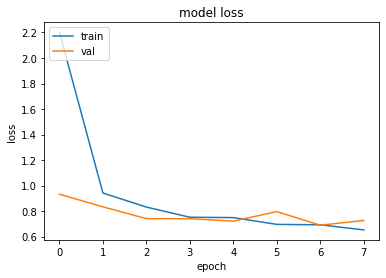

In [ ]:
#Visualization of the Loss
from matplotlib import pyplot as plt
plt.plot(InceptionResNetV2_history.history['loss'])
plt.plot(InceptionResNetV2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

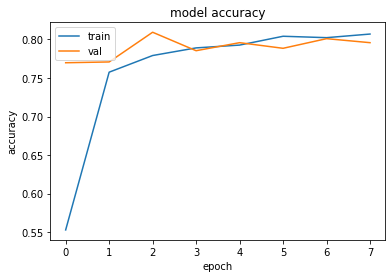

In [ ]:
plt.plot(InceptionResNetV2_history.history['accuracy'])
plt.plot(InceptionResNetV2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Making the predictions and evaluating the model

In [ ]:
def decode_predictions(preds, top=5, class_list_path=None):
    results = []
    top_indices = (-preds).argsort()[0]
    for i in range(top):
        breed = list(test_dataset.class_indices.keys())[top_indices[i]]
        prob = preds[0][top_indices[i]]
        results.append((breed, prob))
    return results

In [ ]:
import PIL
from keras.applications.xception import preprocess_input
def visualize_pred(model):
  img_path, img_class = get_random_image()

  sp = plt.subplot(1, 1, 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title('Real: ' + img_class, fontsize=16)
  plt.imshow(img, cmap='gray')    
  plt.show()

  image = PIL.Image.open(img_path)
  image = np.array(image.resize((299,299)))

  test_image = np.expand_dims(image, axis=0)
  b = preprocess_input(image)
  result = model.predict(np.expand_dims(b, axis=0))
  max_index_col = np.argmax(result[0], axis=0)
  print(max_index_col)
  print('Predicted:', decode_predictions(result, top=5))
  list(test_dataset.class_indices.keys())[max_index_col]
  print('actual class prediction:', result[0, test_dataset.class_indices[img_class]])


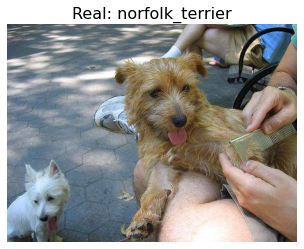

79
Predicted: [('norfolk_terrier', 0.96383023), ('west_highland_white_terrier', 0.011400672), ('norwich_terrier', 0.009356313), ('cairn', 0.0022329404), ('australian_terrier', 0.0012021824)]
actual class prediction: 0.96383023


In [ ]:
visualize_pred(model)

## Model Performance Evaluation

In [ ]:
# Getting test accuracy and loss
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy of InceptionResNetV2 the test images: {:.2f}%'.format(test_acc * 100))

38/38 [==============================] - 268s 7s/step - loss: 0.4238 - accuracy: 0.8750
Accuracy of InceptionResNetV2 the test images: 87.50%


# Experiment number 2: MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.optimizers import Adam

## Loading&Building NN

In [ ]:
model=MobileNet(input_tensor=input ,weights='imagenet',include_top=False) 

In [ ]:
#Make every layer untrainable.
model.trainable = False
# add new classifier layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(120, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 150, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 150, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 150, 150, 32)     128       
 ation)                                                    

## Training NN

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = [
      EarlyStopping(
          monitor='val_accuracy',
          mode='max', patience=5,
          restore_best_weights=True),
      ModelCheckpoint(model_dir + '/MobileNet.h5',
                      verbose=1,
                      monitor='val_accuracy',
                      save_best_only=True),
]

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
MobileNet_history = model.fit(x = train_dataset, validation_data = validation_dataset, epochs = EPOCH, callbacks=[es])

Epoch 1/60
120/120 [==============================] - ETA: 0s - loss: 4.4799 - accuracy: 0.0617
Epoch 1: val_accuracy improved from -inf to 0.23229, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/MobileNet.h5
120/120 [==============================] - 151s 1s/step - loss: 4.4799 - accuracy: 0.0617 - val_loss: 3.2778 - val_accuracy: 0.2323
Epoch 2/60
120/120 [==============================] - ETA: 0s - loss: 3.0365 - accuracy: 0.2333
Epoch 2: val_accuracy improved from 0.23229 to 0.43854, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/MobileNet.h5
120/120 [==============================] - 147s 1s/step - loss: 3.0365 - accuracy: 0.2333 - val_loss: 2.1994 - val_accuracy: 0.4385
Epoch 3/60
120/120 [==============================] - ETA: 0s - loss: 2.3473 - accuracy: 0.3737
Epoch 3: val_accuracy improved from 0.43854 to 0.49167, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/MobileNet.h5
120/120 [==============================] - 146s 1s/step - 

## Visualization of Loss and Accuracy

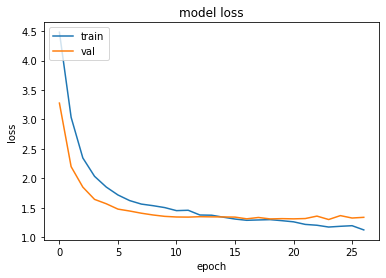

In [ ]:
#Visualization of the Loss
from matplotlib import pyplot as plt
plt.plot(MobileNet_history.history['loss'])
plt.plot(MobileNet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

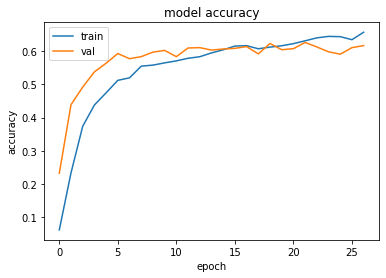

In [ ]:
plt.plot(MobileNet_history.history['accuracy'])
plt.plot(MobileNet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Making the predictions and evaluating the model

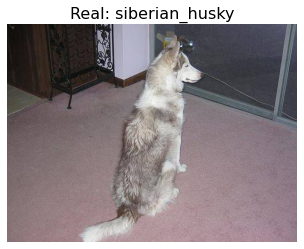

101
Predicted: [('siberian_husky', 0.6625701), ('malamute', 0.26269776), ('eskimo_dog', 0.012910676), ('cardigan', 0.009538011), ('wire-haired_fox_terrier', 0.006829572)]
actual class prediction: 0.6625701


In [ ]:
visualize_pred(model)

## Model Performance Evaluation

In [ ]:
# Getting test accuracy and loss
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy of MobileNet on the test images: {:.2f}%'.format(test_acc * 100))

38/38 [==============================] - 10s 254ms/step - loss: 0.9304 - accuracy: 0.7158
Accuracy of MobileNet on the test images: 71.58%


# Experiment number 3: Xception

In [ ]:
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception

model = Xception(input_tensor=input, include_top=False, weights="imagenet")

83697664/83683744 [==============================] - 1s 0us/step


## Loading&Building NN

In [ ]:
#Make every layer untrainable.
model.trainable = False
# add new classifier layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(120, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Training NN

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = [
      EarlyStopping(
          monitor='val_accuracy',
          mode='max', patience=5,
          restore_best_weights=True),
      ModelCheckpoint(model_dir + '/Xception.h5',
                      verbose=1,
                      monitor='val_accuracy',
                      save_best_only=True),
]

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
Xception_history = model.fit(x = train_dataset, validation_data = validation_dataset, epochs = EPOCH, callbacks=[es])

Epoch 1/60
120/120 [==============================] - ETA: 0s - loss: 2.3222 - accuracy: 0.5060
Epoch 1: val_accuracy improved from -inf to 0.75521, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/Xception.h5
120/120 [==============================] - 174s 1s/step - loss: 2.3222 - accuracy: 0.5060 - val_loss: 0.8778 - val_accuracy: 0.7552
Epoch 2/60
120/120 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.7294
Epoch 2: val_accuracy did not improve from 0.75521
120/120 [==============================] - 159s 1s/step - loss: 0.9254 - accuracy: 0.7294 - val_loss: 0.8690 - val_accuracy: 0.7510
Epoch 3/60
120/120 [==============================] - ETA: 0s - loss: 0.7943 - accuracy: 0.7648
Epoch 3: val_accuracy improved from 0.75521 to 0.76250, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/Xception.h5
120/120 [==============================] - 160s 1s/step - loss: 0.7943 - accuracy: 0.7648 - val_loss: 0.8295 - val_accuracy: 0.7625
Epoch 4/

## Visualization of Loss and Accuracy

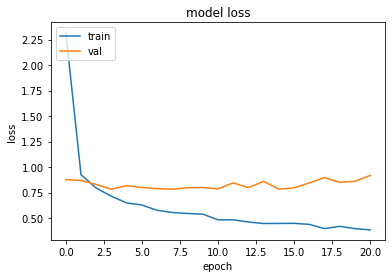

In [ ]:
#Visualization of the Loss
from matplotlib import pyplot as plt
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

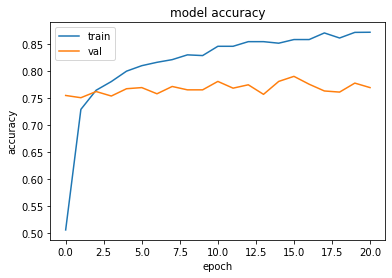

In [ ]:
plt.plot(Xception_history.history['accuracy'])
plt.plot(Xception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Making the predictions and evaluating the model

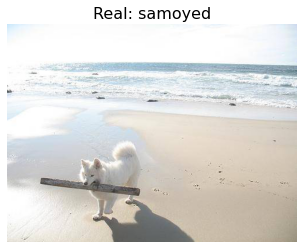

94
Predicted: [('samoyed', 0.95323426), ('pomeranian', 0.032897998), ('great_pyrenees', 0.0032374589), ('papillon', 0.0029720098), ('golden_retriever', 0.0017938089)]
actual class prediction: 0.95323426


In [ ]:
visualize_pred(model)

## Model Performance Evaluation

In [ ]:
# Getting test accuracy and loss
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy of Xception on the test images: {:.2f}%'.format(test_acc * 100))

38/38 [==============================] - 20s 513ms/step - loss: 0.4816 - accuracy: 0.8633
Accuracy of Xception on the test images: 86.33%


# Experiment number 4: InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# load model without classifier layers
model = InceptionV3(input_tensor=input,
                    include_top=False,
                    weights="imagenet")

87924736/87910968 [==============================] - 1s 0us/step


## Loading&Building NN

In [ ]:
# add new classifier layers
model.trainable = False
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(120, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_410 (Conv2D)            (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_410 (Batch  (None, 149, 149, 32  96         ['conv2d_410[0][0]']             
 Normalization)                 )                                                           

## Training NN

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = [
      EarlyStopping(
          monitor='val_accuracy',
          mode='max', patience=5,
          restore_best_weights=True),
      ModelCheckpoint(model_dir + '/InceptionV3.h5',
                      verbose=1,
                      monitor='val_accuracy',
                      save_best_only=True),
]

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
InceptionV3_history = model.fit(x = train_dataset, validation_data = validation_dataset, epochs = EPOCH, callbacks=[es])


Epoch 1/60
120/120 [==============================] - ETA: 0s - loss: 2.8573 - accuracy: 0.3911
Epoch 1: val_accuracy improved from -inf to 0.70729, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionV3.h5
120/120 [==============================] - 159s 1s/step - loss: 2.8573 - accuracy: 0.3911 - val_loss: 1.1012 - val_accuracy: 0.7073
Epoch 2/60
120/120 [==============================] - ETA: 0s - loss: 1.2361 - accuracy: 0.6544
Epoch 2: val_accuracy improved from 0.70729 to 0.72500, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionV3.h5
120/120 [==============================] - 151s 1s/step - loss: 1.2361 - accuracy: 0.6544 - val_loss: 0.9722 - val_accuracy: 0.7250
Epoch 3/60
120/120 [==============================] - ETA: 0s - loss: 1.0315 - accuracy: 0.7065
Epoch 3: val_accuracy improved from 0.72500 to 0.73542, saving model to /mntDrive/MyDrive/DeepLearning/adv_end/models/InceptionV3.h5
120/120 [==============================] - 149s 1s/s

## Visualization of Loss and Accuracy

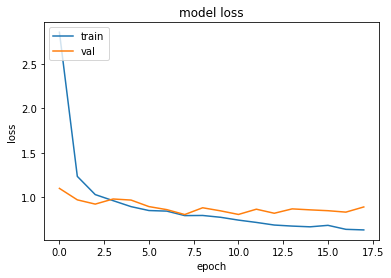

In [ ]:
#Visualization of the Loss
from matplotlib import pyplot as plt
plt.plot(InceptionV3_history.history['loss'])
plt.plot(InceptionV3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

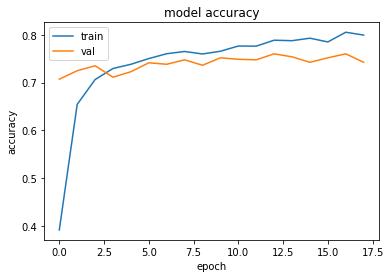

In [ ]:
plt.plot(InceptionV3_history.history['accuracy'])
plt.plot(InceptionV3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Making the predictions and evaluating the model

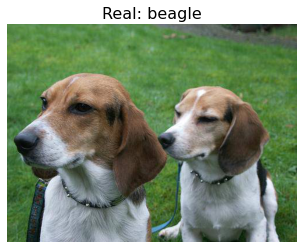

9
Predicted: [('beagle', 0.9853719), ('walker_hound', 0.0052977623), ('english_foxhound', 0.0041134246), ('basset', 0.0026427608), ('bluetick', 0.00064079725)]
actual class prediction: 0.9853719


In [ ]:
visualize_pred(model)

## Model Performance Evaluation

In [ ]:
# Getting test accuracy and loss
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy of InceptionV3 on the test images: {:.2f}%'.format(test_acc * 100))

38/38 [==============================] - 12s 317ms/step - loss: 0.4898 - accuracy: 0.8433
Accuracy of InceptionV3 on the test images: 84.33%


# **Concluisions**

For conclusion we have tested 4 diffrent networks. </br>
In each test we ran the same 2extra layers, fully connected layer of 1024 neurons and our exit layer of fully connected 120 neurons using softmax. </br>
In addition of that, we have used the same augmentation on the same data for every run to see the diffrences in every model for every test. </br>
</br>
The best model performences is InceptionResNetV2 that got 87.5% accuracy on our test data, not far from him is Xception model with 86.33%. </br>
MobileNet is the worst tested model in our project with only 71.58%!


Transfer learning is definitely going to be one of the key drivers for machine learning and deep learning success in mainstream adoption in the industry. I definitely hope to see more pre-trained models and innovative case studies which leverage this concept and methodology. 